# Rethinking Statistics course in Stan - Week 8

Lecture 15: Multilevel Models

- [Video](https://www.youtube.com/watch?v=AALYPv5xSos)
- [Slides](https://speakerdeck.com/rmcelreath/l15-statistical-rethinking-winter-2019)

Lecture 16: Multilevel Models 2

- [Video](https://www.youtube.com/watch?v=ZG3Oe35R5sY)
- [Slides](https://speakerdeck.com/rmcelreath/l16-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week08.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week08_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
%load_ext watermark
%watermark -n -u -p pandas,numpy,cmdstanpy,plotnine

Last updated: Fri Dec 31 2021

pandas   : 1.3.4
numpy    : 1.21.4
cmdstanpy: 1.0.0
plotnine : 0.8.0



In [3]:
def waic(stan_fit):
    log_lik = stan_fit.stan_variable('log_lik')
    lik_mean = np.ma.masked_invalid(np.exp(log_lik).mean(axis=0))
    lppd = np.log(lik_mean).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)

## Exercise 1

> Revisit the Reed frog survival data, `reedfrogs`, and add the predation and size treatment variables to the varying intercepts model. Consider models with either predictor alone, both predictors, as well as a model including their interaction. What do you infer about the causal influence of these predictor variables? Also focus on the inferred variation across tanks (the σ across tanks). Explain why it changes as it does across models with different predictors included.

Let's get the data.

In [4]:
d = pd.read_csv('./dat/reedfrogs.csv', header=0, sep=';')
d['tank'] = d.index
d['pred'] = pd.factorize(d['pred'])[0]
d['volume'] = d['size'].replace({'small':0, 'big':1})
d.tail(3)

,density,pred,size,surv,propsurv,tank,volume
45,35,1,small,12,0.342857,45,0
46,35,1,small,31,0.885714,46,0
47,35,1,small,17,0.485714,47,0


Now to define a series of models. The first is just the varying intercepts model from the text.

Model 1:

In [5]:
model = '''

data {
    int n;
    int tank[n];
    int density[n];
    int surv[n];
}

parameters {
    real a_bar;
    real sigma;
    vector[n] a;
}

model {
    // prior
    a_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    a ~ normal(a_bar, sigma);
    // likelihood
    surv ~ binomial_logit(density, a);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = binomial_logit_lpmf(surv[i] | density[i], a[i]);
  }
}

'''

stan_file = './stn/week08_01a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_1a = CmdStanModel(stan_file=stan_file)
model_1a.compile()

data = d[['tank', 'density', 'surv']].copy()
data = data.to_dict(orient='list')
data['n'] = len(data['surv'])
fit_1a = model_1a.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_01a.stan to exe file /home/jovyan/work/statret/stn/week08_01a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_01a
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Model 2 (pred):

In [6]:
model = '''
data {
    int n;
    int tank[n];
    int density[n];
    int pred[n];
    int surv[n];
}

parameters {
    real a_bar;
    real sigma;
    real bp;
    vector[n] a;
}

transformed parameters {
    vector[n] alpha;
    for (i in 1:n) {alpha[i] = a[i] + bp*pred[i];}
}

model {
    // prior
    a_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    a ~ normal(a_bar, sigma);
    bp ~ normal(-0.5, 1);
    // likelihood
    for (i in 1:n) {surv[i] ~ binomial_logit(density[i], alpha[i]);}
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = binomial_logit_lpmf(surv[i] | density[i], alpha[i]);
  }
}
'''

stan_file = './stn/week08_01b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_1b = CmdStanModel(stan_file=stan_file)
model_1b.compile()

data = d[['tank', 'density', 'pred', 'surv']].copy()
data = data.to_dict(orient='list')
data['n'] = len(data['surv'])
fit_1b = model_1b.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_01b.stan to exe file /home/jovyan/work/statret/stn/week08_01b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_01b
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Model 3 (size):

In [7]:
model = '''
data {
    int k;
    int n;
    int tank[n];
    int density[n];
    int volume[n];
    int surv[n];
}

parameters {
    real a_bar;
    real sigma;
    vector[k] s;
    vector[n] a;
}

transformed parameters {
    vector[n] alpha;
    for (i in 1:n) {alpha[i] = a[i] + s[volume[i]];}
}

model {
    // prior
    a_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    a ~ normal(a_bar, sigma);
    s ~ normal(0, 0.5);
    // likelihood
    for (i in 1:n) {surv[i] ~ binomial_logit(density[i], alpha[i]);}
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = binomial_logit_lpmf(surv[i] | density[i], alpha[i]);
  }
}
'''

stan_file = './stn/week08_01c.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_1c = CmdStanModel(stan_file=stan_file)
model_1c.compile()

data = d[['tank', 'density', 'volume', 'surv']].copy()
data.volume = data.volume + 1
data = data.to_dict(orient='list')
data['n'] = d.surv.size
data['k'] = d.volume.nunique()
fit_1c = model_1c.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_01c.stan to exe file /home/jovyan/work/statret/stn/week08_01c
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_01c
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Model 4 (pred + size):

In [8]:
model = '''
data {
    int n;
    int k;
    int tank[n];
    int density[n];
    int volume[n];
    int pred[n];
    int surv[n];
}

parameters {
    real a_bar;
    real sigma;
    real bp;
    vector[k] s;
    vector[n] a;
}

transformed parameters {
    vector[n] alpha;
    for (i in 1:n) {alpha[i] = a[i] + bp*pred[i] + s[volume[i]];}
}

model {
    // prior
    a_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    a ~ normal(a_bar, sigma);
    s ~ normal(0, 0.5);
    // likelihood
    for (i in 1:n) {surv[i] ~ binomial_logit(density[i], alpha[i]);}
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = binomial_logit_lpmf(surv[i] | density[i], alpha[i]);
  }
}
'''

stan_file = './stn/week08_01d.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_1d = CmdStanModel(stan_file=stan_file)
model_1d.compile()

data = d[['tank', 'density', 'volume', 'pred', 'surv']].copy()
data.volume = data.volume + 1
data = data.to_dict(orient='list')
data['n'] = d.surv.size
data['k'] = d.volume.nunique()
fit_1d = model_1d.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_01d.stan to exe file /home/jovyan/work/statret/stn/week08_01d
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_01d
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Model 5 (pred + size + interaction):

In [9]:
model = '''
data {
    int n;
    int k;
    int tank[n];
    int density[n];
    int volume[n];
    int pred[n];
    int surv[n];
}

parameters {
    real a_bar;
    real sigma;
    vector[k] bp;
    vector[k] s;
    vector[n] a;
}

transformed parameters {
    vector[n] alpha;
    for (i in 1:n) {alpha[i] = a[i] + bp[volume[i]]*pred[i] + s[volume[i]];}
}

model {
    // prior
    a_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    a ~ normal(a_bar, sigma);
    s ~ normal(0, 0.5);
    // likelihood
    for (i in 1:n) {surv[i] ~ binomial_logit(density[i], alpha[i]);}
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = binomial_logit_lpmf(surv[i] | density[i], alpha[i]);
  }
}
'''

stan_file = './stn/week08_01e.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_1e = CmdStanModel(stan_file=stan_file)
model_1e.compile()

data = d[['tank', 'density', 'volume', 'pred', 'surv']].copy()
data.volume = data.volume + 1
data = data.to_dict(orient='list')
data['n'] = d.surv.size
data['k'] = d.volume.nunique()
fit_1e = model_1e.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_01e.stan to exe file /home/jovyan/work/statret/stn/week08_01e
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_01e
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


I coded the interaction model (`samples_5`) using a non-centered parameterization. The interaction itself is done by creating a `bp` parameter for each size value. In this way, the effect of `pred` depends upon `volume`. First let's consider the WAIC scores:

In [10]:
sc = {
    '1' : waic(fit_1a),
    '2' : waic(fit_1b),
    '3' : waic(fit_1c),
    '4' : waic(fit_1d),
    '5' : waic(fit_1e),
}
scores = pd.DataFrame(sc.items(), columns=['model','waic'])
scores.sort_values(by='waic')

,model,waic
1,2,198.930
4,5,199.883
3,4,200.320
0,1,200.928
2,3,201.042


These models are really very similar in expected out-of-sample accuracy. The tank variation is huge. But take a look at the posterior distributions for predation and size. You'll see that predation does seem to matter, as you'd expect. Size matters a lot less. So while predation doesn't explain much of the total variation, there is plenty of evidence that it is a real effect. Remember: We don't select a model using WAIC
(or LOO). A predictor can make little difference in total accuracy but still be a real causal effect.

Let's look at all the sigma posterior distributions:

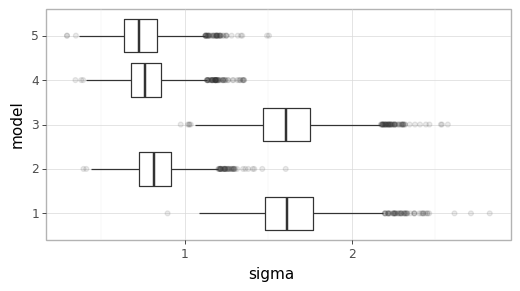

<ggplot: (8766302518772)>

In [11]:
atts = ['sigma']
fits = {'1':fit_1a, '2':fit_1b, '3':fit_1c, '4':fit_1d, '5':fit_1e}
akk = []
for k in fits.keys():
    df = fits[k].draws_pd(vars=atts)
    df['model'] = k
    akk.append(df)
im = pd.concat(akk)

(
    ggplot(im)
    + aes(x='model', y='sigma')
    + coord_flip()
    + geom_boxplot(outlier_alpha=0.1)
    + theme_light()
    + theme(figure_size=(6, 3))
)

The two models that omit predation, `model_11` and `model_13`, have larger values of `sigma`. This is because predation explains some of the variation among tanks. So when you add it to the model, the variation in the tank intercepts gets smaller.

## Exercise 2

> In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3. You're going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in data `bangladesh` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on two of them for this practice problem:

> 1. `district`: ID number of administrative district each woman resided in
2. `use.contraception`: An indicator (0/1) of whether the woman was using contraception

In [12]:
d = pd.read_csv('./dat/bangladesh.csv', header=0, sep=';')
d['did'] = pd.factorize(d['district'])[0]
d['conc'] = d['use.contraception']
d.head()

,woman,district,use.contraception,living.children,age.centered,urban,did,conc
0,1,1,0,4,18.4400,1,0,0
1,2,1,0,1,-5.5599,1,0,0
2,3,1,0,3,1.4400,1,0,0
3,4,1,0,4,8.4400,1,0,0
4,5,1,0,1,-13.5590,1,0,0


In [13]:
model = '''

data {
    int n;
    int k;
    int did[n];
    int conc[n];
}

parameters {
    vector[k] alpha;
}

model {
    // prior
    alpha ~ normal(0, 1.5);
    // likelihood
    for (i in 1:n) { conc[i] ~ bernoulli_logit(alpha[did[i]]); }
}

'''

stan_file = './stn/week08_02a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_2a = CmdStanModel(stan_file=stan_file)
model_2a.compile()

data = d[['did', 'conc']].copy()
data.did = data.did + 1
data = data.to_dict(orient='list')
data['n'] = d.conc.size
data['k'] = d.did.nunique()
fit_2a = model_2a.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_02a.stan to exe file /home/jovyan/work/statret/stn/week08_02a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_02a
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Now for the ordinary fixed effect model:

In [14]:
model = '''

data {
    int n;
    int k;
    int did[n];
    int conc[n];
}

parameters {
    real alpha_bar;
    real sigma;
    vector[k] alpha;
}

model {
    // prior
    alpha_bar ~ normal(0, 1.5);
    sigma ~ exponential(1);
    alpha ~ normal(alpha_bar, sigma);
    // likelihood
    for (i in 1:n) { conc[i] ~ bernoulli_logit(alpha[did[i]]); }
}

'''

stan_file = './stn/week08_02b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_2b = CmdStanModel(stan_file=stan_file)
model_2b.compile()

data = d[['did', 'conc']].copy()
data.did = data.did + 1
data = data.to_dict(orient='list')
data['n'] = d.conc.size
data['k'] = d.did.nunique()
fit_2b = model_2b.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_02b.stan to exe file /home/jovyan/work/statret/stn/week08_02b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_02b
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Now let's extract the samples, compute posterior mean probabilities in each district, and plot it all:

In [15]:
def logit2prob(logits):
    odds = np.exp(logits)
    probs = odds/(1+odds)
    return probs

In [16]:
prob2a = logit2prob(fit_2a.stan_variable(var='alpha').mean(axis=0))
prob2b = logit2prob(fit_2b.stan_variable(var='alpha').mean(axis=0))
prob_line = logit2prob(fit_2b.stan_variable(var='alpha_bar').mean(axis=0))

The red points are the fixed estimations. The blue points are the varying effects. As you'd expect, they are shrunk towards the mean (the _red_ line). Some are shrunk more than others. The third district from the left shrunk a lot. Let's look at the sample size in each district: district 3 has only 2 women sampled. So it shrinks a lot. There are couple of other districts, like 49 and 54, that also have very few women sampled. But their fixed estimates aren't as extreme, so they don't shrink as much as district 3 does. All of this is explained by partial pooling, of course.

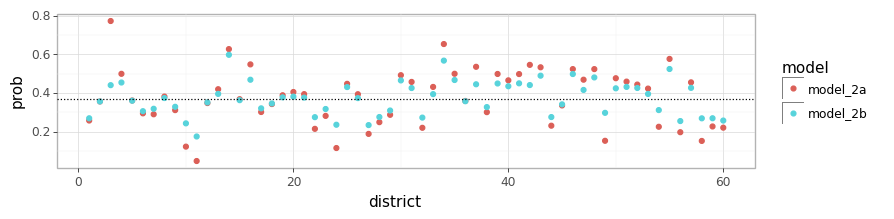

<ggplot: (8766301777661)>

In [17]:
im = pd.DataFrame({'model_2a':prob2a, 'model_2b':prob2b}).reset_index()
im['district'] = im.index+1
im = pd.melt(im, id_vars=['district'], value_vars=['model_2a','model_2b'], var_name='model', value_name='prob')

(
    ggplot(im)
    + aes(x='district', y='prob', color='model')
    + geom_point()
    + geom_hline(yintercept=prob_line, linetype='dotted')
    + theme_light()
    + theme(figure_size=(9,2))
)

## Exercise 3

Return to the Trolley data, (`Trolley`), from Chapter 12. Define and fit a varying intercepts model for these data. By this I mean to add an intercept parameter for the individual to the linear model. Cluster the varying intercepts on individual participants, as indicated by the unique values in the id variable. Include action, intention, and contact as before. Compare the varying intercepts model and a model that ignores individuals, using both WAIC/LOO and posterior predictions. What is the impact of individual variation in these data?

In [18]:
d = pd.read_csv('./dat/Trolley.csv', header=0, sep=';')
elvl = d['edu'].unique()
cat = {elvl[i]:i for i in [7 , 0 , 6 , 4 , 2 , 1, 3, 5]}
d['edu_cat'] = d.edu.replace(cat)
d['age_std'] = (d['age'] - d['age'].mean())/d['age'].std()
d['id'] = pd.factorize(d['id'])[0]
d.tail(3)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,edu_cat,age_std
9927,ilshi,7,7,330,66,1,Graduate Degree,0,1,0,shi,0,5,2.003041
9928,ilswi,2,18,330,66,1,Graduate Degree,0,1,0,swi,0,5,2.003041
9929,nfrub,2,17,330,66,1,Graduate Degree,1,0,0,rub,1,5,2.003041


First, let's load the data and re-run the old model from Chapter 12:

In [19]:
model = '''

data {
    int n;
    int k;
    int action[n];
    int contact[n];
    int intention[n];
    int response[n];
}

parameters {
    ordered[k] cutpoints;
    real bA;
    real bC;
    real bI;
    real bIA;
    real bIC;
}

transformed parameters {
    vector[n] phi;
    vector[n] BI;
    for (i in 1:n) {
        BI[i] = bI + bIA*action[i] + bIC*contact[i];
        phi[i] = bA*action[i] + bC*contact[i] + BI[i]*intention[i];
    }
}

model {
    // prior
    cutpoints ~ normal(0,15);
    bA ~ normal(0,0.5);
    bC ~ normal(0,0.5);
    bI ~ normal(0,0.5);
    bIA ~ normal(0,0.5);
    bIC ~ normal(0,0.5);
    // likelihood
    for (i in 1:n) { response[i] ~ ordered_logistic(phi[i], cutpoints); }
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) { log_lik[i] = ordered_logistic_lpmf(response[i] | phi[i], cutpoints); }
}

'''

stan_file = './stn/week08_03a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_3a = CmdStanModel(stan_file=stan_file)
model_3a.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_03a.stan to exe file /home/jovyan/work/statret/stn/week08_03a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_03a
INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
data = d[['action', 'contact', 'intention', 'response']].copy()
data = data.to_dict(orient='list')
data['n'] = len(data['response'])
data['k'] = d.response.nunique()-1
fit_3a = model_3a.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Now to run the varying intercept model, we need to build a valid individual ID variable. The IDs in the data are long tags, so we can coerce them to integers in many ways. What is important is that the index values go from 1 (_zero in python_) to the number of individuals.

In [21]:
model = '''

data {
    int n;
    int k;
    int p;
    int id[n];
    int action[n];
    int contact[n];
    int intention[n];
    int response[n];
}

parameters {
    ordered[k] cutpoints;
    vector[p] alpha;
    real sigma;
    real bA;
    real bC;
    real bI;
    real bIA;
    real bIC;
}

transformed parameters {
    vector[n] phi;
    vector[n] BI;
    for (i in 1:n) {
        BI[i] = bI + bIA*action[i] + bIC*contact[i];
        phi[i] = alpha[id[i]] + bA*action[i] + bC*contact[i] + BI[i]*intention[i];
    }
}

model {
    // prior
    cutpoints ~ normal(0,15);
    bA ~ normal(0,0.5);
    bC ~ normal(0,0.5);
    bI ~ normal(0,0.5);
    bIA ~ normal(0,0.5);
    bIC ~ normal(0,0.5);
    sigma ~ exponential(1);
    alpha ~ normal(0, sigma);
    // likelihood
    for (i in 1:n) { response[i] ~ ordered_logistic(phi[i], cutpoints); }
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) { log_lik[i] = ordered_logistic_lpmf(response[i] | phi[i], cutpoints); }
}

'''

stan_file = './stn/week08_03b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
model_3b = CmdStanModel(stan_file=stan_file)
model_3b.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week08_03b.stan to exe file /home/jovyan/work/statret/stn/week08_03b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week08_03b
INFO:cmdstanpy:found newer exe file, not recompiling


In [22]:
data = d[['action', 'contact', 'intention', 'response', 'id']].copy()
data['id'] = data.id+1
data = data.to_dict(orient='list')
data['n'] = len(data['response'])
data['k'] = d.response.nunique()-1
data['p'] = d.id.nunique()
fit_3b = model_3b.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


We can begin by comparing the posterior distributions. The original coefficients are:

In [23]:
fit_3a.summary().loc[['bA','bC','bI','bIA', 'bIC']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
bA,-0.5,0.0,0.1,-0.6,-0.5,-0.4,2039.8,4.1,1.0
bC,-0.3,0.0,0.1,-0.5,-0.3,-0.2,2339.6,4.7,1.0
bI,-0.3,0.0,0.1,-0.4,-0.3,-0.2,1970.8,3.9,1.0
bIA,-0.4,0.0,0.1,-0.6,-0.4,-0.3,2323.9,4.6,1.0
bIC,-1.2,0.0,0.1,-1.4,-1.2,-1.1,2418.3,4.8,1.0


And the new ones, having added the individual IDs, are:

In [24]:
fit_3b.summary().loc[['bA','bC','bI','bIA', 'bIC']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
bA,-0.7,0.0,0.1,-0.7,-0.7,-0.6,3177.6,3.8,1.0
bC,-0.5,0.0,0.1,-0.6,-0.5,-0.3,3263.7,3.9,1.0
bI,-0.4,0.0,0.1,-0.5,-0.4,-0.3,2756.8,3.3,1.0
bIA,-0.6,0.0,0.1,-0.7,-0.6,-0.4,3204.4,3.8,1.0
bIC,-1.7,0.0,0.1,-1.8,-1.7,-1.5,3175.2,3.8,1.0


Everything has gotten more negative. This is because there is a lot of individual variation in average rating, look at the distribution for sigma. That is on the $logit$ scale, so that's a lot of variation on the probability scale. That variation in average rating was hiding some of the effect of the treatments. We get more precision by conditioning on individual.

The WAIC comparison can also help show how much variation comes from individual differences in average rating:

In [25]:
sc = {
    'a' : waic(fit_3a),
    'b' : waic(fit_3b),
}
scores = pd.DataFrame(sc.items(), columns=['model','waic'])
scores.sort_values(by='waic')

,model,waic
1,b,31058.393
0,a,36929.550


The WAIC difference is massive. This is consistent with individual variation in average rating being a major effect in this sample. This is all quite typical of likert-scale data, in my experience. Individuals anchor on different points and this adds noise. When we have repeat samples from the same individual, we can condition away some of that noise and get more precise estimates of the treatment effects.